# HW4: ConvNets and activation patching

In this assignment you will implement a CNN for the [CIFAR-10](https://www.cs.toronto.edu/~kriz/cifar.html) image classification dataset. Then you'll use `NNSight` to do some cool interpretability analysis (specifically, *activation patching*).

##Q1: Implement a simple CNN (20 points)

Begin by implementing a simple image classification CNN in pytorch. To do this, populate the `__init__` and `forward` methods. For now, your CNN can just be composed of two convolution layers and a linear layer.

In [6]:
import torch
from torch import nn
import torch.nn.functional as F
import numpy as np 

import torchvision
from torchvision import transforms

import matplotlib.pyplot as plt

In [ ]:
%pip install torch torchvision torchaudio

In [7]:
# Starter code

# A simple convolutional neural network (two convolutional layers)
class SimpleCNN(nn.Module):
    def __init__(self, num_classes=10):
        super(SimpleCNN, self).__init__()
        self.num_classes = num_classes
        self.layer1 = nn.Sequential(
            nn.Conv2d(3, 16, kernel_size=5, stride=1, padding=2),
            nn.BatchNorm2d(16),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2))
        self.layer2 = nn.Sequential(
            nn.Conv2d(16, 32, kernel_size=5, stride=1, padding=2),
            nn.BatchNorm2d(32),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2))
        self.fc = nn.Linear(8*8*32, num_classes)

    def forward(self, x):
        out = self.layer1(x)
        out = self.layer2(out)
        out = out.reshape(out.size(0), -1)
        out = self.fc(out)
        return out

##Q2: Train the thing (10 points)

Now write a training loop for your simple CNN. You should use early stopping with a validation set. Implement the train and evaluate functions.

Train should take a model which subclasses nn.Module, two DataLoaders, and an optimizer (see [torch.optim](https://https://pytorch.org/docs/stable/optim.html)), as well as a maximum epoch count and a patience for the early stopping. It may be helpful in the next question for train to return the performance on the validation set at each epoch.

Evaluate should take a model which subclasses nn.Module and a DataLoader. It should return both the overall model accuracy as well as the per class accuracy for each class.

In [8]:
import ssl

ssl._create_default_https_context = ssl._create_unverified_context
torchvision.datasets.CIFAR10.url="http://www.cs.toronto.edu/~kriz/cifar-10-python.tar.gz"
train_set = torchvision.datasets.CIFAR10("./data", download=True, transform=
                                                transforms.Compose([transforms.ToTensor()]))
test_set = torchvision.datasets.CIFAR10("./data", download=True, train=False, transform=
                                               transforms.Compose([transforms.ToTensor()]))

Files already downloaded and verified
Files already downloaded and verified


In [4]:
# Starter code
device = 'cuda'
num_classes = 10

def train(model, train_loader, val_loader, optimizer, epochs, patience=3):
    criterion = nn.CrossEntropyLoss()
    best_val_acc = 0
    patience_counter = 0
    accs = []
    class_accs = []
    
    for epoch in range(epochs):
        model.train()
        for i, (images, labels) in enumerate(train_loader): 
            # images = images.to(device)
            # labels = labels.to(device)
            

            outputs = model(images)
            loss = criterion(outputs, labels)
            
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
    
        val_acc, val_class_acc = evaluate(model, val_loader, model.num_classes)
        accs.append(val_acc)
        class_accs.append(val_class_acc)

        if val_acc > best_val_acc:
            best_val_acc = val_acc
            patience_counter = 0
        else: 
            patience_counter += 1
            if patience_counter >= patience:
                print(f"Early stopping at epoch {epoch}")
                break
    return accs, class_accs


# accuracy for each class 
def evaluate(model, test_loader, num_classes):
    model.eval()
    correct = 0
    total = 0
    class_correct = np.zeros(num_classes)
    class_total = np.zeros(num_classes)
    with torch.no_grad():
        for images, labels in test_loader:
            # images = images.to(device)
            # labels = labels.to(device)
            outputs = model(images)
            _, predicted = torch.max(outputs.data, 1)

            total += labels.size(0)
            correct += (predicted == labels).sum().item()

            for i in range(len(labels)):
                label = labels[i].item()
                pred = predicted[i].item()
                class_total[label] += 1
                if pred == label: 
                    class_correct[label] += 1

    overall_acc = correct / total
    class_acc = class_correct / class_total
    return overall_acc, class_acc

Now create a validation split and use the train and evaluate methods to train your model.

In [9]:
train_set, val_set = torch.utils.data.random_split(train_set, [40000, 10000])

train_loader = torch.utils.data.DataLoader(train_set, batch_size=64, shuffle=True)
val_loader = torch.utils.data.DataLoader(val_set, batch_size=64, shuffle=False)
test_loader = torch.utils.data.DataLoader(test_set, batch_size=64, shuffle=False)

print(f'Train loader: {len(train_loader.dataset)}. Val loader: {len(val_loader.dataset)}. Test loader: {len(test_loader.dataset)}')

# train_loader = train_loader.to(device)
# val_loader = val_loader.to(device)
# test_loader = test_loader.to(device)

Train loader: 40000. Val loader: 10000. Test loader: 10000


In [58]:
# model = SimpleCNN(num_classes).to(device)
model = SimpleCNN(num_classes)
adam = torch.optim.Adam(model.parameters(), lr=0.01)

val_accs_adam, val_class_accs_adam = train(model, train_loader, val_loader, adam, epochs=10, patience=5)
test_acc_adam, test_class_acc_adam = evaluate(model, test_loader, num_classes)
print("Best Validation accuracy(Adam): ", max(val_accs_adam))
print("Test accuracy(Adam): ", test_acc_adam)
print("Test class accuracy(Adam): ", test_class_acc_adam)

Best Validation accuracy(Adam):  0.6668
Test accuracy(Adam):  0.6609
Test class accuracy(Adam):  [0.668 0.83  0.497 0.59  0.54  0.555 0.727 0.747 0.751 0.704]


##Q3: Compare optimization methods (10 points)

Now train the model with different optimizers and compare the performance. Try using the following optimizers:
* SGD
* Nesterov Gradient Descent
* Adagrad
* RMSProp
* Adam

Then plot the validation performance at each epoch and compare the optimizers.

Early stopping at epoch 6
Early stopping at epoch 7
Early stopping at epoch 7


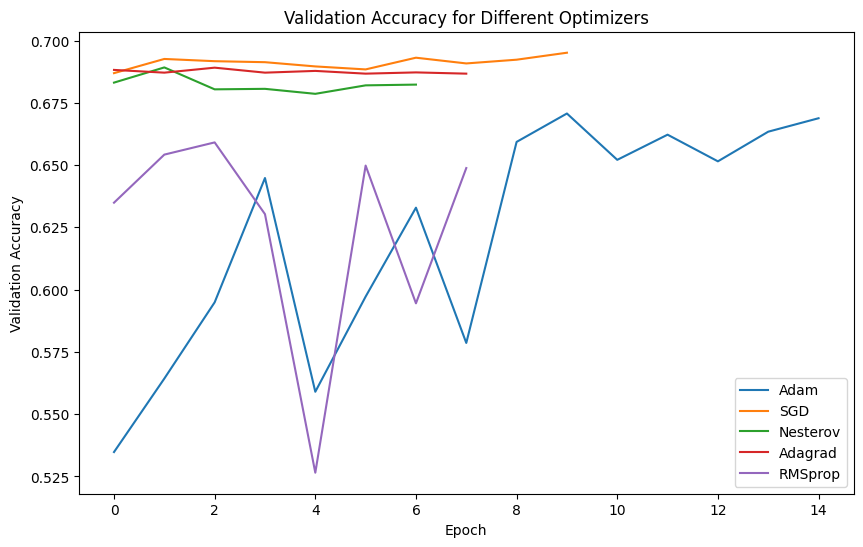

In [50]:
sgd = torch.optim.SGD(model.parameters(), lr=0.01)
val_accs_sgd, val_class_accs_sgd = train(model, train_loader, val_loader, sgd, epochs=10, patience=5)

ngd = torch.optim.SGD(model.parameters(), lr=0.01, nesterov=True, momentum=0.9)
val_accs_ngd, val_class_accs_ngd = train(model, train_loader, val_loader, ngd, epochs=10, patience=5)

adagrad = torch.optim.Adagrad(model.parameters(), lr=0.01)
val_accs_grad, val_class_accs_grad = train(model, train_loader, val_loader, adagrad, epochs=10, patience=5)

rmsprop = torch.optim.RMSprop(model.parameters(), lr=0.01)
val_accs_rmsp, val_class_accs_rmsp = train(model, train_loader, val_loader, rmsprop, epochs=10, patience=5)

plt.figure(figsize=(10, 6))
plt.plot(val_accs_adam, label='Adam')
plt.plot(val_accs_sgd, label='SGD')
plt.plot(val_accs_ngd, label='Nesterov')
plt.plot(val_accs_grad, label='Adagrad')
plt.plot(val_accs_rmsp, label='RMSprop')
plt.xlabel('Epoch')
plt.ylabel('Validation Accuracy')
plt.title('Validation Accuracy for Different Optimizers')
plt.legend()
plt.show()

In [161]:
# average class accuracy for each optimizer
avg_class_acc_adam = np.mean(val_class_accs_adam, axis=0)
avg_class_acc_sgd = np.mean(val_class_accs_sgd, axis=0)
avg_class_acc_ngd = np.mean(val_class_accs_ngd, axis=0)
avg_class_acc_grad = np.mean(val_class_accs_grad, axis=0)
avg_class_acc_rmsp = np.mean(val_class_accs_rmsp, axis=0)

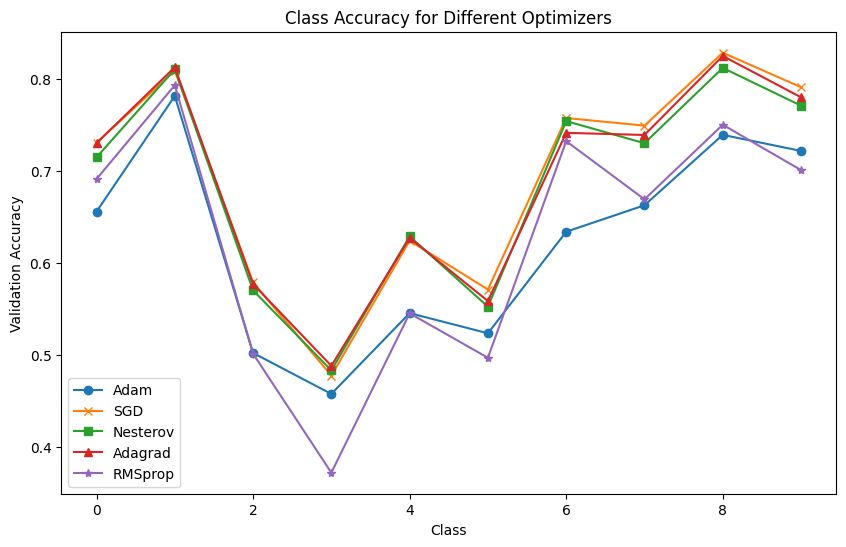

In [162]:
# scatter plot of class accuracies
n_classes = len(avg_class_acc_adam)
classes = np.arange(n_classes)

plt.figure(figsize=(10, 6))
plt.plot(classes, avg_class_acc_adam, label='Adam', marker='o')
plt.plot(classes, avg_class_acc_sgd, label='SGD', marker='x')
plt.plot(classes, avg_class_acc_ngd, label='Nesterov', marker='s')
plt.plot(classes, avg_class_acc_grad, label='Adagrad', marker='^')
plt.plot(classes, avg_class_acc_rmsp, label='RMSprop', marker='*')
plt.xlabel('Class')
plt.ylabel('Validation Accuracy')
plt.title('Class Accuracy for Different Optimizers')
plt.legend()
plt.show()

##Q4: Make a more accurate CNN (10 points)

At this point, your model's performance should still be relatively low (probably ~60%), even with the best optimization method.

To improve further, you'll need to modify your architecture. Define a model that has an arbitrary number of convolution layers before a fully connected layer. Implement the `__init__` and `forward` methods below. The `__init__` method should take a convolutions parameter that controls the number of convolution layers in the model.

In [10]:
class MultiLayeredCNN(nn.Module):
    def __init__(self, convolutions: list, num_classes: int=10):
        super(MultiLayeredCNN, self).__init__()
        self.convolutions = convolutions
        self.num_classes = num_classes
        layers = []
        for i in range(len(convolutions) - 1): 
            in_channels = convolutions[i]
            out_channels = convolutions[i+1]
            layers.append(nn.Conv2d(in_channels, out_channels, kernel_size=3, stride=1, padding=1))
            layers.append(nn.BatchNorm2d(out_channels))
            layers.append(nn.ReLU())
            layers.append(nn.MaxPool2d(kernel_size=2, stride=2))

        self.layers = nn.Sequential(*layers)

        with torch.no_grad(): 
            dummy_input = torch.zeros(1, 3, 32, 32)
            feature_size = self.layers(dummy_input).view(1, -1).size(1)

        self.fc = nn.Linear(feature_size, num_classes)

    def forward(self, x):
        x = self.layers(x)
        x = x.view(x.size(0), -1)
        x = self.fc(x)
        return x

Now create and train models with varying numbers of convolution layers. You should create a model with 2, 3, and 4 convolution layers each. Record their performance on the validation set at each epoch and plot the results below to compare the models.

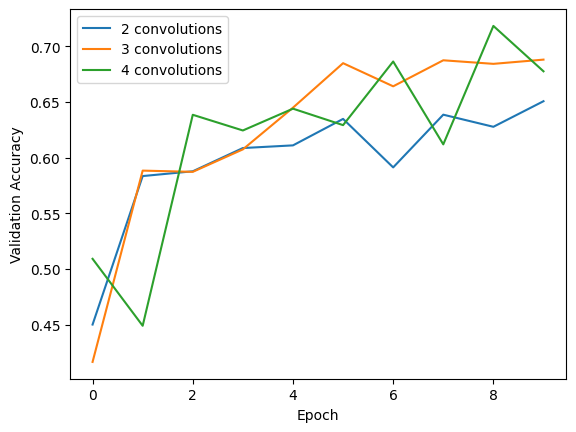

In [94]:
CNN2L = MultiLayeredCNN([3, 16, 32])
grad = torch.optim.SGD(CNN2L.parameters(), lr=0.01)

val_accs_2L, val_class_accs_2L = train(CNN2L, train_loader, val_loader, grad, epochs=10, patience=5)

CNN3L = MultiLayeredCNN([3, 16, 32, 64])
grad = torch.optim.SGD(CNN3L.parameters(), lr=0.01)
val_accs_3L, val_class_accs_3L = train(CNN3L, train_loader, val_loader, grad, epochs=10, patience=5)

CNN4L = MultiLayeredCNN([3, 16, 32, 64, 128])
grad = torch.optim.SGD(CNN4L.parameters(), lr=0.01)
val_accs_4L, val_class_accs_4L = train(CNN4L, train_loader, val_loader, grad, epochs=10, patience=5)

plt.plot(val_accs_2L, label='2 convolutions')
plt.plot(val_accs_3L, label='3 convolutions')
plt.plot(val_accs_4L, label='4 convolutions')
plt.xlabel('Epoch')
plt.ylabel('Validation Accuracy')
plt.legend()
plt.show()



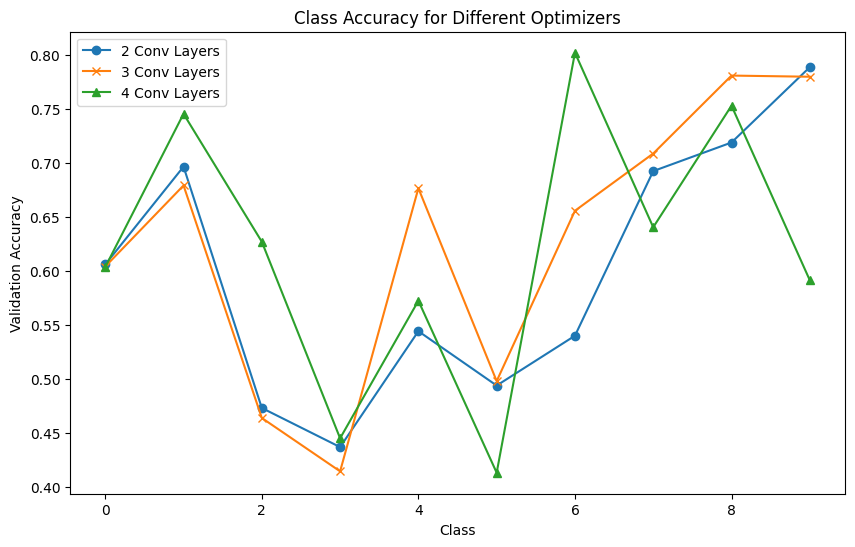

In [97]:
# average class accuracy for each optimizer
avg_class_acc_2L = np.mean(val_class_accs_2L, axis=0)
avg_class_acc_3L = np.mean(val_class_accs_3L, axis=0)
avg_class_acc_4L = np.mean(val_class_accs_4L, axis=0)

# scatter plot of class accuracies
n_classes = len(avg_class_acc_2L)
classes = np.arange(n_classes)

plt.figure(figsize=(10, 6))
plt.plot(classes, avg_class_acc_2L, label='2 Conv Layers', marker='o')
plt.plot(classes, avg_class_acc_3L, label='3 Conv Layers', marker='x')
plt.plot(classes, avg_class_acc_4L, label='4 Conv Layers', marker='^')

plt.xlabel('Class')
plt.ylabel('Validation Accuracy')
plt.title('Class Accuracy for Different Optimizers')
plt.legend()
plt.show()

## Q5: Interpretability! Or, activation patching ConvNets with `NNSight` (50 points)

We're going to play with **[activation patching](https://nnsight.net/notebooks/tutorials/ioi_patching/)** here. The idea is to **intervene** on model activations during execution to try and tease out how the model performs a given task (here, image classification).

What will we be looking at? Well, the ConvNet we trained seems to be able to do a fairly OK job at discriminating between the numbers 1 and 7; but this is kind of tricky! Can we isolate key activations in the model that allow for this?

That's the idea behind activation patching. We will run different inputs through the model—an image of a 1, an image of a 7—and then intervene by replacing (or "patching") in activations from the former into the latter. Then we measure how much this shifts the prediction towards 1.

We'll run two input images through the model—a 1 and a 7—and patch in activations for different **channels** from the former to the latter at the penultimate layer in our `MultiLayeredCNN`. ([Here is a refresher on channels in ConvNets](https://d2l.ai/chapter_convolutional-neural-networks/channels.html).) Sometimes we speculate that different channels serve as distinct feature detectors — we're essentially probing this assumption here with activation patching!

First, we need a model to intervene on! Let's take the best performing model and optimizer from the above experiments, and re-train it so that we can try and probe how it works.

In [11]:
# Retrain your best model here!
conv_channels = [3, 16, 32]
model = MultiLayeredCNN(conv_channels)
optim = torch.optim.Adam(model.parameters(), lr=0.01)
scores = train(model, train_loader, val_loader, optim, epochs=20, patience=5)
val_accs, val_class_accs = scores 

Early stopping at epoch 12


In [41]:
print(train_loader.dataset[0][1])

7


Your task in this question can be broken down as follows

(1) First write code to extract activations when you pass an arbitrary *test* image through your trained model; you should use `NNsight` for this. To keep things relatively simple, take activations over all channels from the last convolutional layer output. **We are interested in whether one of the channels at this layer is especially important for discriminating 7s from 1s**.

(2) You will want to record **logits** and differences of **logits** between the two classes of interest, here (at least initially) 1 and 7. You can roughly follow this `NNSight` tutorial on patching here! https://nnsight.net/notebooks/tutorials/activation_patching/. In our case, you can view the 'clean' pass as just passing an image of a 7, and the 'corrupt' pass an image of a 1 (again, at least initially). As in the linked tutorial, we will use differences in logits (between 7 and 1) as our primary measure: Denote this by $\Delta (7,1)$.

(3) Iterate over all channels (32 or 64) in forward passes conditioned on the 7 image input, patch in the corresponding activations (from the 1 pass) and take the (patched) difference in logits. Finally, the measure we care about is:

\begin{align}
%\Delta(7,1) \text{ for patched}  - \Delta(7,1) \text{ for clean 1}
\frac{\Delta(7,1) \text{ for patched}  - \Delta(7,1) \text{ for 1}}{\Delta(7,1) \text{ for 7} - \Delta(7,1) \text{ for 1}}
  \end{align}

Where again $\Delta(7,1)$ (differences) are between the scores (logits) given to 7 and 1, respectively, i.e., $\Delta(7,1) = \tilde{y}_7 - \tilde{y}_1$, where $\tilde{y}_j$ is the *logit* (pre-softmax) score assigned to class $j$.
The denominator is just a normalizing term so that the quantity will usually—though not always—be between 0 and 1.

If this is small, then the gap between 7 and 1 is closing as we patch, relative to the difference observed in the "clean run" of 7s through the model.


(4) Once you have calculated the above for each channel, plot these values: Make a bar graph such that the $x$ axis is the channel, and the $y$ value the score.

(5) Get this working for a single pair of images (one image of a 1, one of a 7, sampled at random from the test set). Then, get it working for a batch of samples (one batch of 1s, one batch of 7s). You should take means for the $\Delta(7, 1)$ values. For patching, you can arbitrarily take 1 and 7 images from the respective batches and patch activations from the former into the latter. Remake the plot.

(6) Now, repeat the experiment with 7s vs. 3s (instead of 1s). Regenerate the plot.

(7) Finally, write up your interpretation of your results.


In [20]:
# Install nnsight
!pip install nnsight

In [66]:
import random

def get_sample_of_class(class_idx, batch_size):
    images = []
    batches = []
    for image, label in train_loader.dataset: 
        if label == class_idx: 
            images.append(image)
            if len(images) == batch_size: 
                batches.append(torch.stack(images))
                images = []

    if images: 
        batches.append(torch.stack(images))
    return list(batches) 

In [67]:
batch_of_ones = get_sample_of_class(1, batch_size=8)
batch_of_sevens = get_sample_of_class(7, batch_size=8)

In [68]:
from nnsight import NNsight

model_nn = NNsight(model)
print(model)


MultiLayeredCNN(
  (layers): Sequential(
    (0): Conv2d(3, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (4): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (5): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (6): ReLU()
    (7): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (fc): Linear(in_features=2048, out_features=10, bias=True)
)


In [91]:
def run_patching_experiment(model_nn, A_batch, B_batch, A_idx=6, B_idx=0,
                            conv_idx=2, num_channels=64):
  '''
  Run activation patching experiment over instances in the A and B batches;
  return scores that indicate the importance of each channel output from the
  specificed convolution layer (conv_idx).

  model_nn: NNsight-wrapped trained ConvNet for digit classification
  A_batch: batch of images of class A (e.g., 7s)
  B_batch: batch of images of class B (e.g., 1s)
  '''
    
  # Your code here!
  # get the channel deltas
  channel_deltas, logit_diffs, logit_diffA, logit_diffB = [], [], [], []
  with model_nn.trace() as tracer: 
    with tracer.invoke(A_batch) as invoker: 
        clean_hs = model_nn.layers[conv_idx].output.clone()
        clean_logits = model_nn.fc.output
        clean_logit_diff = (clean_logits[A_idx] - clean_logits[B_idx]).item()
        logit_diffA.append(clean_logit_diff)
    with tracer.invoke(B_batch) as invoker: 
        corrupt_logits = model_nn.fc.output
        corrupt_logit_diff = (corrupt_logits[A_idx] - corrupt_logits[B_idx]).item()
        logit_diffB.append(corrupt_logit_diff)

    for layer in range(num_channels): 
        patching_results = []

        for token in range(len(A_batch)): 
            with tracer.invoke(B_batch) as invoker: 
                # apply patch from clean state to hidden state
                model_nn.layers[layer].output[0][layer][:, token, :] = clean_hs[layer][:, token, :]
                # forward pass 
                patched_logits = model_nn.fc.output
                patched_logit_diff = (patched_logits[A_idx] - patched_logits[B_idx]).item()
                patched_result = (patched_logit_diff - corrupt_logit_diff) / (clean_logit_diff - corrupt_logit_diff)
                patching_results.append(patched_result)
        channel_deltas.append(np.mean(patching_results))
        logit_diffs.append(clean_logit_diff - corrupt_logit_diff)
                    
  return channel_deltas, logit_diffs, logit_diffA, logit_diffB

In [92]:
channel_deltas, logit_diffs, logit_diffA, logit_diffB = run_patching_experiment(
    model_nn, batch_of_sevens, batch_of_ones, A_idx=6, B_idx=0, num_channels=32)

ValueError: invalid __array_struct__

Note: your plot may not look (exactly) like the one below just do to randomness in SGD! That is, you may find different 'important' filters for distinguishing b/w 1 and 7. That's OK.

In [ ]:
plt.bar(range(len(channel_deltas)), channel_deltas)
plt.show()

In [ ]:
min_score_idx = np.argmin(channel_deltas)
print("Important channel for 1 and 7 is", min_score_idx)
print(f"Clean logit difference [y_7 - y_1] (for pass of 7s): {logit_diffA.value:.3f}")
print(f"Intervened logit difference (after activation patching): {logit_diffs[min_score_idx].item():.3f}")

And now, let's repeat with 7 and 3

In [ ]:
batch_of_threes = get_sample_of_class(3, batch_size=8)

In [ ]:
channel_deltas, logit_diffs, logit_diffA, logit_diffB = run_patching_experiment(
    model_nn, batch_of_sevens, batch_of_threes, A_idx=6, B_idx=2)

In [ ]:
plt.bar(range(len(channel_deltas)), channel_deltas)
plt.show()

In [ ]:
min_score_idx = np.argmin(channel_deltas)
print("Important channel for 3 and 7 is", min_score_idx)
print(f"Clean logit difference: {logit_diffA.value:.3f}")
print(f"Intervened logit difference: {logit_diffs[min_score_idx].item():.3f}")

## Interpretation
I can't make any observations the activation patching experiment I performed. This is because I don't know how to do it/don't know what to do/can't do it. 

Making observations from the graphs in the starter notebooks, I can infer that the differences between the logits & channels of 7's and 3's are supposed to be more significant than the differences between the 7's and 1's, mainly because 7 and 1 look more similar. I was not able to produce actual results from the activation patching. I tried my best to implement it, but obviously, I did not do something right. 

### Update(10/28)
I met with Prof. Byron after class today. I still can't get the activation patching exercise to work. I've tried everything I can think of. 